In [1]:
import gurobi as gb
import networkx as nx
import matplotlib.pyplot as plt
import random

from networkx import bipartite
from IPython.display import SVG

In [2]:
random.seed(42)

# Generating complete bipartite graph

In [3]:
candidate_location_nb = 2
demand_nb = 5

G = bipartite.random_graph(candidate_location_nb, demand_nb, 1)
print("The graph has", G.number_of_nodes(),
      "nodes and", G.number_of_edges(), "edges.")

The graph has 7 nodes and 10 edges.


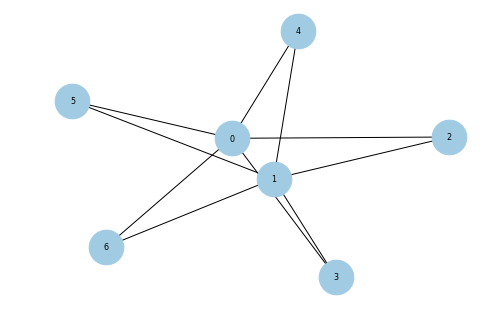

In [4]:
%matplotlib inline
pos = nx.spring_layout(G)
nx.draw(G,pos, node_color='#A0CBE2', width=1, node_size=1200, 
        with_labels=True, hold=None, font_size=8)

In [5]:
c_nodes, d_nodes = bipartite.sets(G)

# Setting the graph attributes for our problem

In [6]:
min_demand = 100
max_demand = 500
demand = {i: random.randint(min_demand, max_demand) for i in d_nodes}
nx.set_node_attributes(G, demand, name="demand")

min_fixed_charge = 1000
max_fixed_charge = 10000
fixed_charge = {i: random.randint(min_fixed_charge, max_fixed_charge) \
                for i in c_nodes}
nx.set_node_attributes(G, fixed_charge, name="fixed charge")

min_distance = 50
max_distance = 100
distance = {(i,j): random.randint(min_distance, max_distance) \
            for i, j in G.edges(c_nodes)}
nx.set_edge_attributes(G, distance, name="distance")

min_D = 60
max_D = 80    
D = {i: random.randint(min_D, max_D) for i in d_nodes}
nx.set_node_attributes(G, D, name="D")

v = random.randint(10, 50)

p = random.randint(1, candidate_location_nb)

In [7]:
def regenerate_node(G, node):
    for (i, j) in G.edges(node):
        distance[(i, j)] = random.randint(min_distance, max_distance)
        G[i][j]["distance"] = distance[(i, j)]
    D[node] = random.randint(min_D, max_D)
    G.nodes[node]["D"] = D[node]

In [8]:
G.nodes(data=True)

NodeDataView({0: {'bipartite': 0, 'fixed charge': 5012}, 1: {'bipartite': 0, 'fixed charge': 4657}, 2: {'bipartite': 1, 'demand': 427, 'D': 60}, 3: {'bipartite': 1, 'demand': 157, 'D': 62}, 4: {'bipartite': 1, 'demand': 112, 'D': 66}, 5: {'bipartite': 1, 'demand': 479, 'D': 67}, 6: {'bipartite': 1, 'demand': 240, 'D': 76}})

In [9]:
G.edges(data=True)

EdgeDataView([(0, 2, {'distance': 58}), (0, 3, {'distance': 97}), (0, 4, {'distance': 56}), (0, 5, {'distance': 93}), (0, 6, {'distance': 97}), (1, 2, {'distance': 84}), (1, 3, {'distance': 55}), (1, 4, {'distance': 87}), (1, 5, {'distance': 77}), (1, 6, {'distance': 52})])

# Checking if the graph is correct
Here we need to check if all demand nodes have at least one edge where the distance is less than the maximum distance.<br\>
If a node does not correspond to this constraint, we regenerate all the random numbers concerning the distance for this node

In [10]:
for node in d_nodes:
    min_d = max_demand
    while min_d > G.nodes[node]["D"]:
        for (i, j) in G.edges(node):
            min_d = G[i][j]["distance"] if G[i][j]["distance"] < min_d else min_d
        
        print("Node", node, "min_d", min_d, "D", G.nodes[node]["D"])
        if min_d > G.nodes[node]["D"]:
            print("Regeneration of node",node)
            regenerate_node(G, node)
            min_d = max_demand
        print()

Node 2 min_d 58 D 60

Node 3 min_d 55 D 62

Node 4 min_d 56 D 66

Node 5 min_d 77 D 67
Regeneration of node 5

Node 5 min_d 62 D 80

Node 6 min_d 52 D 76



In [11]:
N = {i:[j for _, j in G.edges(i) if G[i][j]["distance"] < G.nodes[i]["D"]]\
      for i in d_nodes}

In [12]:
hcf = gb.Model()

In [13]:
# Variable definition
x = hcf.addVars(c_nodes, vtype=gb.GRB.BINARY, name="x")
z = hcf.addVars(d_nodes, vtype=gb.GRB.BINARY, name="z")

In [14]:
# Objective function
hcf.setObjective(z.prod(demand), gb.GRB.MAXIMIZE)

In [15]:
hcf.addConstr(x.sum() == p, name="FacilityNb")
hcf.addConstrs((x.sum(N[i]) >= z[i] for i in d_nodes), name="covering")
hcf.update()
hcf.write('hcf2.lp')

In [16]:
hcf.optimize()

Optimize a model with 6 rows, 7 columns and 12 nonzeros
Variable types: 0 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 539.0000000
Presolve removed 6 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 876 539 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.760000000000e+02, best bound 8.760000000000e+02, gap 0.0000%


# Solution Drawing

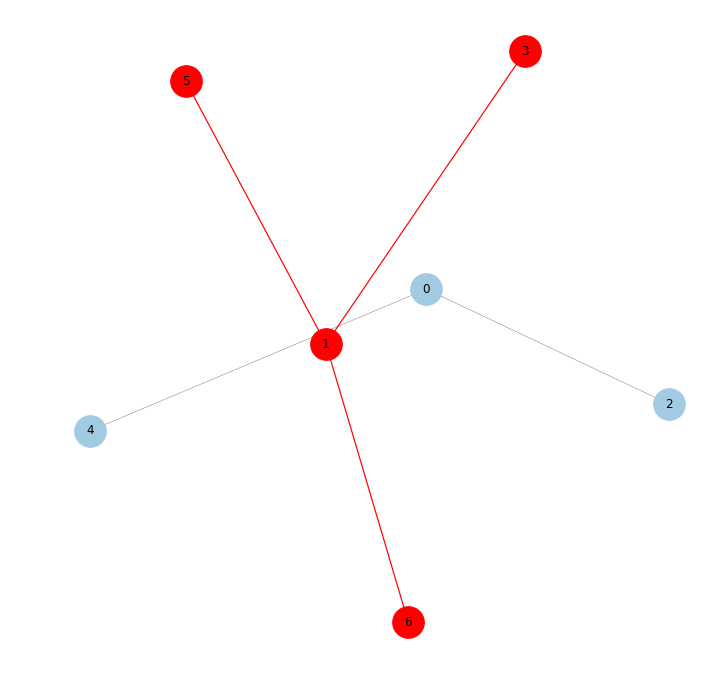

In [17]:
%matplotlib inline
plt.figure(figsize=(demand_nb // 2 + 10, demand_nb // 2 + 10))

pos = nx.spring_layout(G)

activated_edge = [(i, j) for i in d_nodes for j in N[i] if x[j].x > 0 and z[i].x > 0]
not_activated_edge = [(i, j) for i in d_nodes for j in N[i] if x[j].x <= 0 or z[i].x <= 0]

nx.draw_networkx_edges (G, pos, edgelist=activated_edge, edge_color='r', width = 1.2)
nx.draw_networkx_edges (G, pos, edgelist=not_activated_edge, edge_color='black', width=0.5, alpha = 0.5)

nodelab = {i:i for i in G.nodes()}

active_facility = [i for i in c_nodes if x[i].x > 0]
not_active_facility = [i for i in c_nodes if x[i].x <= 0]
active_demand = [i for i in d_nodes if z[i].x > 0]
not_active_demand = [i for i in d_nodes if z[i].x <= 0]

nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=1000, nodelist=active_facility + active_demand, node_color ='r')
nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=1000, nodelist=not_active_facility + not_active_demand, node_color ='#A0CBE2')

nx.draw_networkx_labels(G, pos, labels=nodelab);
nx.draw(G, pos, with_labels=True,  alpha=0.0, node_color ='b', node_size=500, nodelabels=nodelab)
